In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV,cross_val_score,train_test_split
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
import tensorflow as tf
from tensorflow import python
from tensorflow import metrics


In [2]:
df = pd.read_csv(r'./dataset/air_quality_data_fix.csv')

In [3]:
df.head()

,latitude,longitude,dateTime,regionCode,universal_aqi,universal_aqi_category,dominant_pollutant,co,no2,o3,...,pm25,so2,health_general_population,health_elderly,health_lung_disease,health_heart_disease,health_athletes,health_pregnant_women,health_children,City
0,-7.294524,112.732623,2024-11-24T08:00:00Z,id,26,Low air quality,pm25,488.99,18.79,84.07,...,89.18,4.21,Reduce the intensity of your outdoor activitie...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,Avoid intense activities outdoors or postpone ...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,Surabaya
1,-7.296518,112.639345,2024-11-24T08:00:00Z,id,19,Poor air quality,pm25,489.34,8.71,89.47,...,113.85,5.66,Avoid intense activities outdoors or postpone ...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,Surabaya
2,-7.251514,112.759883,2024-11-24T08:00:00Z,id,38,Low air quality,o3,492.09,16.41,78.74,...,45.67,3.64,Reduce the intensity of your outdoor activitie...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,Avoid intense activities outdoors or postpone ...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,Surabaya
3,-7.283691,112.745216,2024-11-24T08:00:00Z,id,30,Low air quality,pm25,489.48,14.84,82.55,...,75.29,3.98,Reduce the intensity of your outdoor activitie...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,Avoid intense activities outdoors or postpone ...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,Surabaya
4,-7.262437,112.721854,2024-11-24T08:00:00Z,id,30,Low air quality,pm25,491.03,16.86,82.08,...,75.09,4.18,Reduce the intensity of your outdoor activitie...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,Avoid intense activities outdoors or postpone ...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,Surabaya


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense

In [5]:
# Pisahkan fitur (X) dan target (y)
X = df[['co', 'no2', 'o3', 'pm10','pm25','so2']]
y = df['universal_aqi']

In [6]:
# Pastikan y diubah menjadi array numpy sebelum reshape
y = y.values.reshape(-1, 1)

# Normalisasi data menggunakan MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

In [7]:
# 5. Mengubah data menjadi bentuk sekuensial untuk RNN/LSTM (samples, timesteps, features)
timesteps = 5  # Menggunakan 5 timestep sebelumnya untuk prediksi
X_seq, y_seq = [], []
for i in range(len(X) - timesteps):
    X_seq.append(X[i:i + timesteps])
    y_seq.append(y[i + timesteps])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

In [8]:
# 6. Membagi data menjadi train set dan test set
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

rnn_model = Sequential([
    SimpleRNN(128, return_sequences=True, activation='tanh', input_shape=(timesteps, X_seq.shape[2])),
    Dropout(0.2),
    SimpleRNN(64, return_sequences=True, activation='tanh'),
    Dropout(0.2),
    SimpleRNN(32, activation='tanh'),
    Dense(10, activation='relu'),
    Dense(1, activation='linear')
])

C:\Users\mucha\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
rnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [11]:
# Menambahkan callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metrik yang dipantau
    patience=10,         # Jumlah epoch tanpa peningkatan sebelum berhenti
    restore_best_weights=True  # Mengembalikan bobot terbaik
)

In [12]:
# Melatih model RNN dengan EarlyStopping
rnn_history = rnn_model.fit(
    X_train, y_train,
    epochs=50,  # Maksimal epoch
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]  # Tambahkan EarlyStopping di sini
)

Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.2216 - mae: 0.2977 - val_loss: 0.0107 - val_mae: 0.0794
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0153 - mae: 0.0959 - val_loss: 0.0079 - val_mae: 0.0669
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0104 - mae: 0.0780 - val_loss: 0.0065 - val_mae: 0.0589
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095 - mae: 0.0745 - val_loss: 0.0071 - val_mae: 0.0631
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0086 - mae: 0.0700 - val_loss: 0.0062 - val_mae: 0.0572
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - mae: 0.0644 - val_loss: 0.0055 - val_mae: 0.0533
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0074 - mae: 0.0656 - val_loss: 0.0051 - val_mae: 0.0489
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0062 - mae: 0.0588 - val_loss: 0.0049 - val_mae: 0.0481
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - mae: 

In [13]:
# 11. Mengevaluasi model
rnn_loss, rnn_mae = rnn_model.evaluate(X_test, y_test)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039 - mae: 0.0414


In [14]:
# 12. Menampilkan hasil evaluasi
results = {
    'RNN': {'Loss': rnn_loss, 'MAE': rnn_mae},
}

print("Hasil Evaluasi Model:")
print(results)

Hasil Evaluasi Model:
{'RNN': {'Loss': 0.0038347153458744287, 'MAE': 0.040654055774211884}}


In [15]:
# Mengevaluasi model
rnn_loss, rnn_mae = rnn_model.evaluate(X_test, y_test)
y_test_inv = scaler_y.inverse_transform(y_test)  # Kembalikan skala asli untuk interpretasi
mae_rnn_scaled = scaler_y.inverse_transform([[rnn_mae]])[0][0]  # MAE RNN dalam skala asli
accuracy_rnn = (1 - (mae_rnn_scaled / np.mean(y_test_inv))) * 100  # Akurasi RNN dalam persentase
print("Hasil Evaluasi Model:")
print(f"RNN - Loss (MSE): {rnn_loss:.4f}, MAE: {rnn_mae:.4f}, Akurasi: {accuracy_rnn:.2f}%")

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039 - mae: 0.0414
Hasil Evaluasi Model:
RNN - Loss (MSE): 0.0038, MAE: 0.0407, Akurasi: 54.95%


In [16]:
# Mengevaluasi model
rnn_loss, rnn_mae = rnn_model.evaluate(X_test, y_test)
# 1 - Normalized MAE
normalized_rnn_mae = rnn_mae / np.mean(y_test)  # Normalisasi MAE RNN
accuracy_rnn = 1 - normalized_rnn_mae
print("Hasil Evaluasi Model:")
print(f"RNN - Loss (MSE): {rnn_loss:.4f}, MAE: {rnn_mae:.4f}, Akurasi: {accuracy_rnn:.4f}")


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039 - mae: 0.0414
Hasil Evaluasi Model:
RNN - Loss (MSE): 0.0038, MAE: 0.0407, Akurasi: 0.9014


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluasi model pada data uji
y_pred_test = rnn_model.predict(X_test)

# Inverse transform hasil prediksi dan data aktual
y_pred_test_scaled = scaler_y.inverse_transform(y_pred_test)
y_test_scaled = scaler_y.inverse_transform(y_test)

# Hitung akurasi menggunakan metrik MAE dan MSE
mae = mean_absolute_error(y_test_scaled, y_pred_test_scaled)
mse = mean_squared_error(y_test_scaled, y_pred_test_scaled)
accuracy = 1 - (mae / np.mean(y_test_scaled))  # Akurasi dalam skala 0-1

# Tampilkan akurasi
print(f"Akurasi Model (skala 0-1): {accuracy:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
# Ambil 3 input terakhir dari data uji
last_inputs = X_test[-3:]  # Mengambil 3 input terakhir
predictions = []

for _ in range(3):  # Prediksi 3 hari ke depan
    # Prediksi untuk setiap timestep
    current_input = last_inputs[-1]  # Gunakan input terakhir untuk prediksi
    prediction = rnn_model.predict(current_input.reshape(1, current_input.shape[0], current_input.shape[1]))
    predictions.append(prediction[0, 0])

    # Update input: Tambahkan prediksi terbaru sebagai langkah berikutnya
    prediction_reshaped = np.full((1, current_input.shape[1]), prediction[0, 0])  # Sesuaikan dengan fitur
    next_input = np.vstack([current_input[1:], prediction_reshaped])  # Geser dan tambahkan prediksi
    last_inputs = np.append(last_inputs[1:], [next_input], axis=0)  # Update 3 input terakhir

# Inverse transform hasil prediksi untuk kembali ke skala asli
predictions_scaled = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))

# Output prediksi 3 hari ke depan
print("\nPrediksi 3 Hari ke Depan:")
for i, pred in enumerate(predictions_scaled.flatten(), 1):
    print(f"Hari ke-{i}: {pred:.4f}")


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Akurasi Model (skala 0-1): 0.9399
Mean Absolute Error (MAE): 2.9271
Mean Squared Error (MSE): 19.8792
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Prediksi 3 Hari ke Depan:
Hari ke-1: 72.2472
Hari ke-2: 48.8324
Hari ke-3: 34.0600


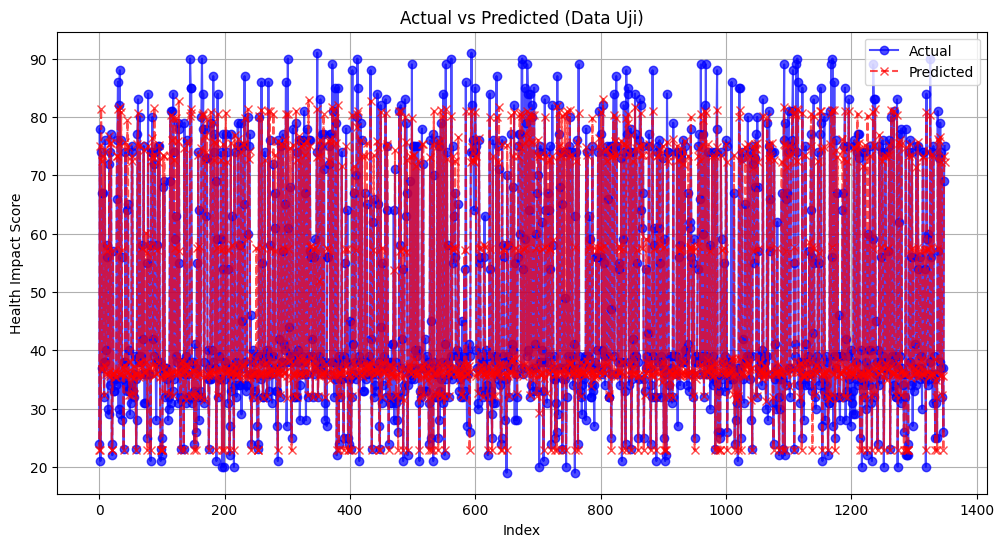

In [18]:
import matplotlib.pyplot as plt

# Visualisasi hasil prediksi vs data aktual untuk data uji
plt.figure(figsize=(12, 6))

# Plot data aktual
plt.plot(y_test_scaled.flatten(), label="Actual", color="blue", linestyle="-", marker="o", alpha=0.7)
# Plot data prediksi
plt.plot(y_pred_test_scaled.flatten(), label="Predicted", color="red", linestyle="--", marker="x", alpha=0.7)

# Tambahkan detail pada grafik
plt.title("Actual vs Predicted (Data Uji)")
plt.xlabel("Index")
plt.ylabel("Health Impact Score")
plt.legend()
plt.grid(True)

# Tampilkan grafik
plt.show()


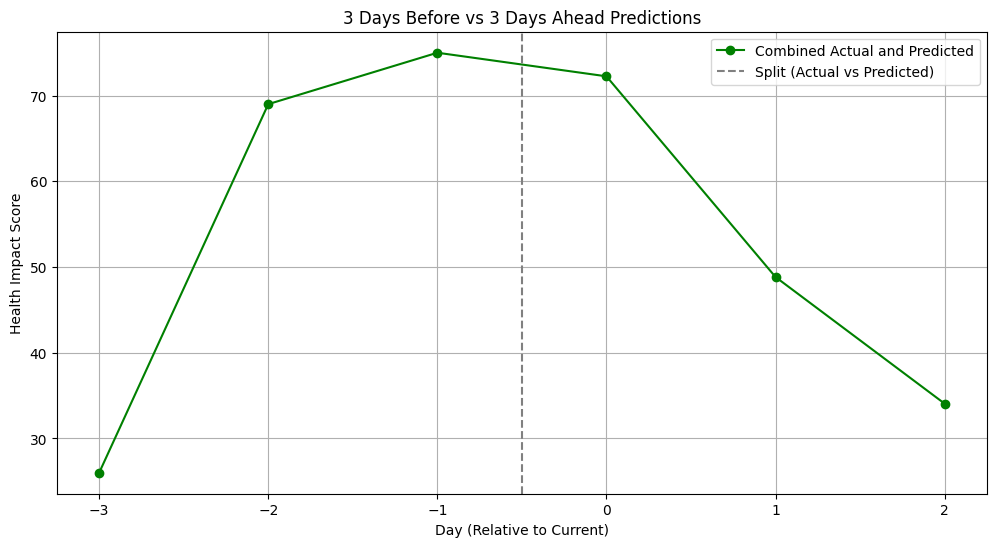

In [19]:
# Fix the dimensions issue by ensuring `days` and `combined_values` have the same length

# Dummy data for demonstration (Replace with actual values)
# Assuming the last 3 actual values from y_test_scaled represent the 3 days before prediction
last_3_actual = y_test_scaled[-3:].flatten()  # Replace with the last 3 actual values
predicted_3_days = predictions_scaled.flatten()  # Replace with actual predictions for 3 days ahead

# Combine last 3 actual and 3 predicted values
combined_values = np.concatenate((last_3_actual, predicted_3_days))

# Correct `days` to match the length of `combined_values`
days = range(-3, 3)  # 3 days before (-3 to -1) and 3 days ahead (0 to 2)

# Visualisasi
plt.figure(figsize=(12, 6))
plt.plot(days, combined_values, label="Combined Actual and Predicted", linestyle='-', marker='o', color='green')

# Highlight the split between actual and predicted
plt.axvline(x=-0.5, color='gray', linestyle='--', label="Split (Actual vs Predicted)")

# Tambahkan detail pada grafik
plt.title("3 Days Before vs 3 Days Ahead Predictions")
plt.xlabel("Day (Relative to Current)")
plt.ylabel("Health Impact Score")
plt.xticks(days)
plt.legend()
plt.grid(True)

# Tampilkan grafik
plt.show()

In [20]:
rnn_model.export("rnnModel")

INFO:tensorflow:Assets written to: rnnModel\assets


INFO:tensorflow:Assets written to: rnnModel\assets


Saved artifact at 'rnnModel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 5, 6), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2095457476176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2095457478096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2095457475984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2095457477520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2095457475792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2095457477712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2095457478864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2095457479056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2095457478288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2095457479824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2095457480016: TensorSpec(shape=(), dtype=tf.reso